In [1]:
## Import packages

import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

pd.set_option('display.max_columns', 500)

%matplotlib inline

In [2]:
# function for displaying eta_squared as measure of effect size in ANOVA

def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov

In [3]:
# Define function for calculating reliability (https://stackoverflow.com/questions/20799403/improving-performance-of-cronbach-alpha-code-python-numpy)

def CronbachAlpha(itemscores):
    # cols are items, rows are observations
    itemscores = np.asarray(itemscores)
    itemvars = itemscores.var(axis=0, ddof=1)
    tscores = itemscores.sum(axis=1)
    nitems = itemscores.shape[1]

    return (nitems / (nitems-1)) * (1 - (itemvars.sum() / tscores.var(ddof=1)))

# Analyzing responsibility data from first studies from summer term 2019


In [4]:
# read file into pd dataframe

data = pd.read_csv(r'responsibility_data_sampled.csv', sep=";")
print(data.shape)
data.head()

(349, 44)


,OID,file_origin,Design,Level,Design_coded,Level_coded,TRUST,DOMINANCE,RHTRUST,Resp_Bic,Resp_Car,Resp_Driver,Resp_Producer,Sex,Age,Car_Owner,km_year,Education,Income,MC_autonom,MC_babyface,MC_baseline,MC_aggressive,MC_wide,Trust_1,Trust_2,Trust_3,RH_Trust_1,RH_Trust_2,RH_Trust_3,RH_Trust_4,RH_Trust_5,RH_Trust_6,RH_Trust_7,RH_Trust_8,RH_Trust_9,Dominance_1,Dominance_2,Dominance_3,Quality_1,Quality_2,Quality_3,Quality_4,Quality_5
0,1,Resp_Aggr_LP,1,1,aggressive,level 5,333.333.333.333.333,466.666.666.666.667,533.333.333.333.333,7,1,3,1,female,24,2,400,5,1,11,2,3,6,4,3,4,3,6,3,4,6,6,6,6,5,6,4,5,5,7,4,6,6,1
1,2,Resp_Aggr_LP,1,0,aggressive,level 3,5,4,522.222.222.222.222,2,4,7,5,female,29,2,2000,5,1,6,1,4,1,3,5,5,5,5,5,5,5,6,4,6,6,5,4,1,7,6,2,7,7,1
2,4,Resp_Aggr_LP,1,1,aggressive,level 5,666.666.666.666.667,433.333.333.333.333,666.666.666.666.667,5,3,6,4,male,19,2,5000,5,1,8,3,2,3,3,7,7,6,7,7,7,7,7,5,7,6,7,5,3,5,7,6,7,6,1
3,5,Resp_Aggr_LP,0,0,baseline,level 3,466.666.666.666.667,333.333.333.333.333,411.111.111.111.111,6,4,6,6,male,50,1,40000,5,0,10,3,6,2,3,4,5,5,5,4,4,4,4,4,4,4,4,2,2,6,6,2,6,6,1
4,6,Resp_Aggr_LP,0,0,baseline,level 3,233.333.333.333.333,466.666.666.666.667,488.888.888.888.889,1,1,7,4,male,21,2,300,5,1,6,5,6,5,5,1,5,1,5,5,6,7,4,1,5,5,6,3,4,7,5,4,7,6,1


In [5]:
print(data['Design'].value_counts().sort_index())
print(data['Level'].value_counts().sort_index())

0    96
1    90
2    79
3    84
Name: Design, dtype: int64
0    180
1    169
Name: Level, dtype: int64


In [6]:
# Delete "Wide"-condition

#annotation Design:
#0 = baseline
#1 = aggressive
#2 = babyfaced
#3 = wide

data = data[data['Design'] < 3]
data.shape

(265, 44)

In [20]:
print(CronbachAlpha(data[['Trust_1', 'Trust_2', 'Trust_3']]))
print(CronbachAlpha(data[['Dominance_1', 'Dominance_2']]))
print(CronbachAlpha(data[['Dominance_1', 'Dominance_2', 'Dominance_3']]))

0.9155902217604114
0.7652380738175026
0.6237120037071122


In [23]:
data['TRUST'] = data[['Trust_1', 'Trust_2', 'Trust_3']].mean(axis=1)
data['DOMINANCE'] = data[['Dominance_1', 'Dominance_2']].mean(axis=1)
print(data['TRUST'].describe())
print(data['DOMINANCE'].describe())

count    265.000000
mean       3.685535
std        1.524236
min        1.000000
25%        2.333333
50%        3.666667
75%        5.000000
max        7.000000
Name: TRUST, dtype: float64
count    265.000000
mean       2.864151
std        1.594391
min        1.000000
25%        1.500000
50%        2.500000
75%        4.000000
max        7.000000
Name: DOMINANCE, dtype: float64


In [24]:
# Two-factorial ANOVA with Design and Level as Factors and TRUST, and DOMINANCE as Outcomes



for resp in ['TRUST', 'DOMINANCE']:

    formula = '{} ~ C(Level) + C(Design) + C(Level):C(Design)'.format(resp)
    model = ols(formula, data).fit()
    aov_table = anova_lm(model, typ=2)
    eta_squared(aov_table)
    print('ANOVA on {}'.format(resp)+'\n',aov_table.round(4))
    print('\n')

ANOVA on TRUST
                       sum_sq     df        F  PR(>F)  eta_sq
C(Level)              1.8305    1.0   0.9341  0.3347  0.0030
C(Design)            97.9290    2.0  24.9860  0.0000  0.1603
C(Level):C(Design)    3.6099    2.0   0.9210  0.3994  0.0059
Residual            507.5565  259.0      NaN     NaN     NaN


ANOVA on DOMINANCE
                       sum_sq     df        F  PR(>F)  eta_sq
C(Level)             10.9867    1.0   5.1529  0.0240  0.0164
C(Design)            99.7276    2.0  23.3867  0.0000  0.1489
C(Level):C(Design)    6.5983    2.0   1.5473  0.2148  0.0099
Residual            552.2248  259.0      NaN     NaN     NaN




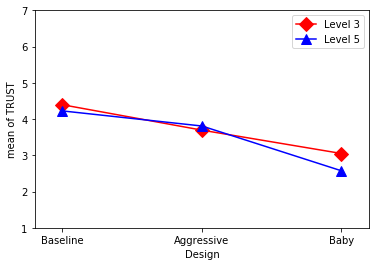

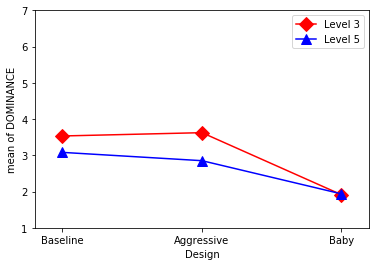

In [25]:
# Visualizing factorial data with statsmodel interaction_plot

for resp in ['TRUST', 'DOMINANCE']:

    fig = interaction_plot(data['Design'], data['Level'], data[resp],
                       colors=['red','blue'], markers=['D','^'], ms=10)

    plt.xticks([0,1,2], labels=['Baseline', 'Aggressive', 'Baby'])
    plt.ylim(1,7)
    plt.legend(['Level 3', 'Level 5'])
    plt.show()


In [26]:
#For each automation level and outcome, display t-tests of mean differences depending on design

#Anotation design:
#0 = baseline
#1 = aggressive
#2 = babyfaced

#Annotation automation level:
#0 = Level 3
#1 = Level 5

design = ['baseline', 'aggressive', 'babyfaced']

for resp in ['TRUST', 'DOMINANCE']:
    for level in sorted(data['Level'].unique()):
        print('\nT-tests for {} on automation level {}'.format(resp, level))
        values = data[data['Level']==level][['Design', resp]]
        for i in range(len(design)):
            if i == 2:
                one = 0
                two = 2
            else:
                one = i
                two = i+1
            
            if stats.levene(values[values['Design']==one][resp], values[values['Design']==two][resp])[1] < .05:
                t, p = stats.ttest_ind(values[values['Design']==one][resp], values[values['Design']==two][resp], 
                                       equal_var=False)
            else:
                t, p = stats.ttest_ind(values[values['Design']==one][resp], values[values['Design']==two][resp])
            print('Comparing means of {} and {}: t-value = {}, p = {}'.format(design[one], design[two], 
                                                                              round(t,4), round(p,4)))


T-tests for TRUST on automation level 0
Comparing means of baseline and aggressive: t-value = 2.3625, p = 0.0202
Comparing means of aggressive and babyfaced: t-value = 2.113, p = 0.038
Comparing means of baseline and babyfaced: t-value = 4.8343, p = 0.0

T-tests for TRUST on automation level 1
Comparing means of baseline and aggressive: t-value = 1.3149, p = 0.1919
Comparing means of aggressive and babyfaced: t-value = 4.3591, p = 0.0
Comparing means of baseline and babyfaced: t-value = 4.887, p = 0.0

T-tests for DOMINANCE on automation level 0
Comparing means of baseline and aggressive: t-value = -0.2781, p = 0.7815
Comparing means of aggressive and babyfaced: t-value = 5.4942, p = 0.0
Comparing means of baseline and babyfaced: t-value = 6.0646, p = 0.0

T-tests for DOMINANCE on automation level 1
Comparing means of baseline and aggressive: t-value = 0.6886, p = 0.4929
Comparing means of aggressive and babyfaced: t-value = 3.1082, p = 0.0025
Comparing means of baseline and babyfaced

In [15]:
# Two-factorial ANOVA with Design and Level as Factors and Resp_Bic, Resp_Car, Resp_Driver, Resp_Producer as Outcomes



for resp in ['Resp_Bic', 'Resp_Car', 'Resp_Driver', 'Resp_Producer']:

    formula = '{} ~ C(Level) + C(Design) + C(Level):C(Design)'.format(resp)
    model = ols(formula, data).fit()
    aov_table = anova_lm(model, typ=2)
    eta_squared(aov_table)
    print('ANOVA on {}'.format(resp)+'\n',aov_table.round(4))
    print('\n')

ANOVA on Resp_Bic
                       sum_sq     df       F  PR(>F)  eta_sq
C(Level)              0.3522    1.0  0.1351  0.7135  0.0005
C(Design)            36.9327    2.0  7.0803  0.0010  0.0516
C(Level):C(Design)    2.9699    2.0  0.5694  0.5666  0.0041
Residual            675.5045  259.0     NaN     NaN     NaN


ANOVA on Resp_Car
                       sum_sq     df        F  PR(>F)  eta_sq
C(Level)             73.3199    1.0  25.9064  0.0000  0.0837
C(Design)            30.1282    2.0   5.3227  0.0054  0.0344
C(Level):C(Design)   39.4793    2.0   6.9747  0.0011  0.0451
Residual            733.0181  259.0      NaN     NaN     NaN


ANOVA on Resp_Driver
                       sum_sq     df        F  PR(>F)  eta_sq
C(Level)            228.1990    1.0  77.0822  0.0000  0.2054
C(Design)            70.1700    2.0  11.8512  0.0000  0.0632
C(Level):C(Design)   46.0212    2.0   7.7726  0.0005  0.0414
Residual            766.7604  259.0      NaN     NaN     NaN


ANOVA on Resp_Producer
 

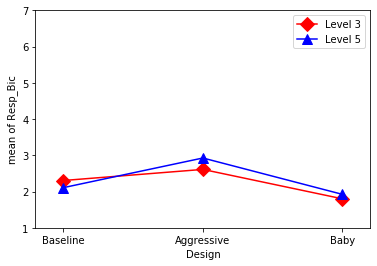

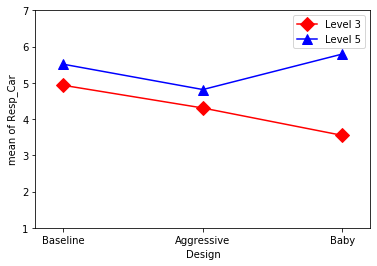

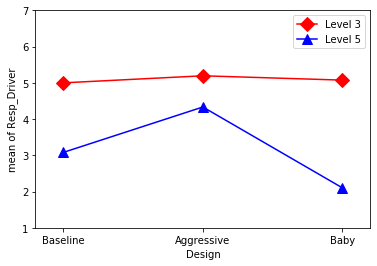

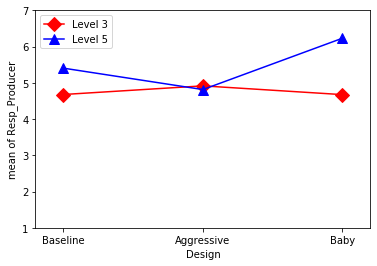

In [9]:
# Visualizing factorial data with statsmodel interaction_plot

for resp in ['Resp_Bic', 'Resp_Car', 'Resp_Driver', 'Resp_Producer']:

    fig = interaction_plot(data['Design'], data['Level'], data[resp],
                       colors=['red','blue'], markers=['D','^'], ms=10)

    plt.xticks([0,1,2], labels=['Baseline', 'Aggressive', 'Baby'])
    plt.ylim(1,7)
    plt.legend(['Level 3', 'Level 5'])
    plt.show()


In [10]:
#Post-hoc testing of mean differences for different levels of automation

# display mean values and std. deviations by level and design

means_by_cond = pd.pivot_table(data, 
                               values=['Resp_Bic', 'Resp_Car', 'Resp_Driver', 'Resp_Producer'], 
                               index=['Level', 'Design'], aggfunc=[np.mean, np.std])
means_by_cond

mean                                           std  \
              Resp_Bic  Resp_Car Resp_Driver Resp_Producer  Resp_Bic   
Level Design                                                           
0     0       2.305085  4.932203    5.000000      4.677966  1.694354   
      1       2.611111  4.305556    5.194444      4.916667  1.678056   
      2       1.800000  3.550000    5.075000      4.675000  1.604481   
1     0       2.108108  5.513514    3.081081      5.405405  1.307750   
      1       2.925926  4.814815    4.333333      4.814815  1.702959   
      2       1.923077  5.794872    2.102564      6.230769  1.579217   

                                                  
              Resp_Car Resp_Driver Resp_Producer  
Level Design                                      
0     0       1.720710    1.473911      1.467354  
      1       2.011672    1.753681      1.841971  
      2       1.153590    1.491643      1.542351  
1     0       1.574477    1.934746      1.739404  
      1       1.972204    2.009412      1.853849  
      2       1.379922    1.602545      1.346761

In [11]:
#Levene's test vor variance equality

W, p = stats.levene(data[(data['Level']==0) & (data['Design']==0)]['Resp_Bic'], data[(data['Level']==0) & (data['Design']==1)]['Resp_Bic'])

print('Levene test statistic: {}, p = {}'.format(W, p))


Levene test statistic: 0.17358043213787364, p = 0.6779092066506753


In [12]:
#t-test

t, p = stats.ttest_ind(data[(data['Level']==0) & (data['Design']==0)]['Resp_Bic'], data[(data['Level']==0) & (data['Design']==1)]['Resp_Bic'])
print('t-value = {}, p = {}'.format(t, p))

t-value = -0.8571175223825969, p = 0.3935832632918522


In [13]:
#For each automation level and outcome, display t-tests of mean differences depending on design

#Anotation design:
#0 = baseline
#1 = aggressive
#2 = babyfaced

#Annotation automation level:
#0 = Level 3
#1 = Level 5

design = ['baseline', 'aggressive', 'babyfaced']

for resp in ['Resp_Bic', 'Resp_Car', 'Resp_Driver', 'Resp_Producer']:
    for level in sorted(data['Level'].unique()):
        print('\nT-tests for {} on automation level {}'.format(resp, level))
        values = data[data['Level']==level][['Design', resp]]
        for i in range(len(design)):
            if i == 2:
                one = 0
                two = 2
            else:
                one = i
                two = i+1
            
            if stats.levene(values[values['Design']==one][resp], values[values['Design']==two][resp])[1] < .05:
                t, p = stats.ttest_ind(values[values['Design']==one][resp], values[values['Design']==two][resp], 
                                       equal_var=False)
            else:
                t, p = stats.ttest_ind(values[values['Design']==one][resp], values[values['Design']==two][resp])
            print('Comparing means of {} and {}: t-value = {}, p = {}'.format(design[one], design[two], 
                                                                              round(t,4), round(p,4)))


T-tests for Resp_Bic on automation level 0
Comparing means of baseline and aggressive: t-value = -0.8571, p = 0.3936
Comparing means of aggressive and babyfaced: t-value = 2.1532, p = 0.0346
Comparing means of baseline and babyfaced: t-value = 1.4866, p = 0.1404

T-tests for Resp_Bic on automation level 1
Comparing means of baseline and aggressive: t-value = -2.5871, p = 0.0113
Comparing means of aggressive and babyfaced: t-value = 2.888, p = 0.0048
Comparing means of baseline and babyfaced: t-value = 0.5547, p = 0.5808

T-tests for Resp_Car on automation level 0
Comparing means of baseline and aggressive: t-value = 1.6142, p = 0.1099
Comparing means of aggressive and babyfaced: t-value = 1.9795, p = 0.0528
Comparing means of baseline and babyfaced: t-value = 4.4446, p = 0.0

T-tests for Resp_Car on automation level 1
Comparing means of baseline and aggressive: t-value = 1.7971, p = 0.0757
Comparing means of aggressive and babyfaced: t-value = -2.8192, p = 0.0059
Comparing means of ba

In [29]:
# Checking for correlations between mediators and responsibility ascription

# Function to calculate p-values

from scipy.stats import pearsonr

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

rho = data[['Resp_Car', 'Resp_Driver', 'Resp_Producer',
            'TRUST', 'DOMINANCE']].corr()
rho = rho.round(2)
pval = calculate_pvalues(data[['Resp_Car', 'Resp_Driver', 'Resp_Producer',
                               'TRUST', 'DOMINANCE']]) 
# create three masks
r1 = rho.applymap(lambda x: '{}*'.format(x))
r2 = rho.applymap(lambda x: '{}**'.format(x))
r3 = rho.applymap(lambda x: '{}***'.format(x))
# apply them where appropriate
rho = rho.mask(pval<=0.1,r1)
rho = rho.mask(pval<=0.05,r2)
rho = rho.mask(pval<=0.01,r3)
print(rho)

               Resp_Car Resp_Driver Resp_Producer    TRUST DOMINANCE
Resp_Car         1.0***    -0.26***       0.52***     0.03      0.08
Resp_Driver    -0.26***      1.0***      -0.18***   0.14**     0.12*
Resp_Producer   0.52***    -0.18***        1.0***  -0.13**      0.03
TRUST              0.03      0.14**       -0.13**   1.0***   0.41***
DOMINANCE          0.08       0.12*          0.03  0.41***    1.0***


In [30]:
# Correlations between car trustworthiness and dominance and resposibility of driver, 
#let's check a moderated mediation analysis

#Import process library
from pyprocessmacro import Process

In [31]:
#Anotation design:
#0 = baseline
#1 = aggressive
#2 = babyfaced

aggr_dict = {0 : 0, 2 : 0, 1 : 1}
baby_dict = {0 : 0, 2 : 1, 1 : 0}
# Add a new columns
data['aggr_design'] = data['Design'].map(aggr_dict).astype('int64')
data['baby_design'] = data['Design'].map(baby_dict).astype('int64')

In [33]:
for y in ['Resp_Car', 'Resp_Driver', 'Resp_Producer']:
    for x in ['aggr_design', 'baby_design']:
        p = Process(data=data, model=7, x=x, y=y, w="Level", 
            m=['TRUST', 'DOMINANCE'],
           controls = [c for c in ['aggr_design', 'baby_design'] if c!=x], controls_in = 'all')
        p.summary()

Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 7

Variables:
    Cons = Cons
    x = aggr_design
    y = Resp_Car
    w = Level
    m1 = TRUST
    m2 = DOMINANCE
Statistical Controls:
 baby_design



Sample size:
265

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = Resp_Car 
OLS Regression Summary

     R²  Adj. R²    MSE      F  df1  df2  p-value
 0.0238   0.0050 3.2390 1.5845    4  260   0.1788

Coefficients

              coeff     se       t      p    LLCI    ULCI
Cons         5.0714 0.3927 12.9128 0.0000  4.3017  5.8412
aggr_design -0.5539 0.2819 -1.9648 0.0505 -1.1065 -0.0014
baby_design -0.4469 0.2794 -1.5998 0.1109 -0.9945  0.1006
TRUST       -0.0444 0.0906 

Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 7

Variables:
    Cons = Cons
    x = baby_design
    y = Resp_Driver
    w = Level
    m1 = TRUST
    m2 = DOMINANCE
Statistical Controls:
 aggr_design



Sample size:
265

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = Resp_Driver 
OLS Regression Summary

     R²  Adj. R²    MSE      F  df1  df2  p-value
 0.0534   0.0351 3.9669 3.6675    4  260   0.0063

Coefficients

              coeff     se       t      p    LLCI   ULCI
Cons         3.6173 0.4761  7.5977 0.0000  2.6842 4.5505
baby_design -0.4181 0.3415 -1.2243 0.2220 -1.0873 0.2512
aggr_design  0.4926 0.2952  1.6684 0.0964 -0.0861 1.0712
TRUST        0.1196 0.095

# Analyzing design pretest

In [14]:
pretest = pd.read_csv('pretest.csv', sep=";")

pretest.head()

,child,ordi,aggre,domi,wide,narrow,relia,trust,age,sex,grad,owner,interest,type,no
0,1.0,6,2,2.0,3,3,5.0,6.0,23,0,0.0,0,4,1,14
1,5.0,7,3,4.0,5,2,2.0,2.0,25,1,1.0,1,2,1,1
2,3.0,3,4,5.0,5,1,7.0,5.0,22,0,0.0,0,4,2,14
3,3.0,6,3,3.0,3,3,5.0,4.0,21,1,0.0,0,4,3,14
4,2.0,5,3,3.0,3,5,4.0,4.0,26,1,1.0,0,4,2,1


In [15]:
pretest.shape

(135, 15)

In [16]:
#Annotation design
#1 = baseline
#2 = wide
#3 = aggressive
#4 = childish
#5 = aggressive2


In [17]:
#delete wide condition

pretest = pretest[pretest['type'] != 2]
pretest.shape

(108, 15)

In [18]:
#Visualize mean values by condition
pretest.columns

Index(['child', 'ordi', 'aggre', 'domi', 'wide', 'narrow', 'relia', 'trust',
       'age', 'sex', 'grad', 'owner', 'interest', 'type', 'no'],
      dtype='object')

In [19]:
means_by_cond = pd.pivot_table(pretest, values=['child', 'ordi', 'aggre'], index=['type'])

means_by_cond = means_by_cond.reset_index()
means_by_cond

,type,aggre,child,ordi
0,1,2.518519,2.814815,4.629630
1,3,3.074074,2.888889,3.851852
2,4,1.518519,4.222222,3.074074
3,5,3.481481,2.538462,3.888889


In [20]:
means = means_by_cond[['aggre', 'child', 'ordi']].T
means

,0,1,2,3
aggre,2.518519,3.074074,1.518519,3.481481
child,2.814815,2.888889,4.222222,2.538462
ordi,4.629630,3.851852,3.074074,3.888889


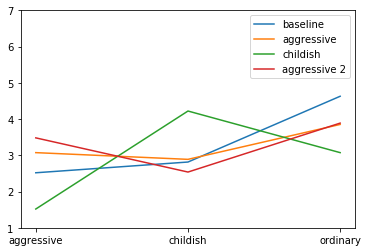

In [21]:
plt.plot(means[0])
plt.plot(means[1])
plt.plot(means[2])
plt.plot(means[3])

plt.legend(['baseline', 'aggressive', 'childish', 'aggressive 2'])
plt.xticks([0,1,2], labels=['aggressive', 'childish', 'ordinary'])
plt.ylim(1,7)

plt.show()

In [22]:
# t-tests for evaluating mean differences on perceptions

#Annotation type
#1 = baseline
#3 = aggressive
#4 = childish
#5 = aggressive2

design = {1:'baseline', 3:'aggressive', 4:'childish', 5:'aggressive 2'}

for perception in ['ordi', 'child', 'aggre']: 
    print('T-tests for {}'.format(perception)+'\n')
    for i in [3,4,5]:
        t, p = stats.ttest_ind(pretest[pretest['type']==1][perception], pretest[pretest['type']==i][perception], nan_policy='omit')
        print('Mean difference between baseline and {}: t = {}, p = {}'.format(design[i], t, p)+'\n\n')
    

T-tests for ordi

Mean difference between baseline and aggressive: t = 1.852817889523018, p = 0.06958725159986436


Mean difference between baseline and childish: t = 3.927041422953478, p = 0.0002544372463183222


Mean difference between baseline and aggressive 2: t = 1.7844672401846167, p = 0.08018223508460963


T-tests for child

Mean difference between baseline and aggressive: t = -0.180108790857026, p = 0.8577672258519458


Mean difference between baseline and childish: t = -3.5119469462795507, p = 0.0009291342693225183


Mean difference between baseline and aggressive 2: t = 0.6653512781265521, p = 0.5088238259070088


T-tests for aggre

Mean difference between baseline and aggressive: t = -1.3082534956552148, p = 0.1965408378946408


Mean difference between baseline and childish: t = 2.971909493767028, p = 0.00447432442754741


Mean difference between baseline and aggressive 2: t = -2.0203332399313667, p = 0.048513597564308335




# Analyzing responsibility data from winter term 2019/2020

## Data from Hildebrand and Bitzer

In [4]:
#Create pandas dataframe from Hildebrand
data1 = pd.read_csv(r'2019-11-14_Hildebrand.csv', sep=";")
print(data1.shape)
data1.head()

(178, 87)


,lfdn,external_lfdn,tester,dispcode,lastpage,quality,duration,c_0001,Studienteilnahme,Trust_Car_1,Trust_Car_2,Trust_Car_3,car_check,Manip_Check_1,Manip_Check_2,Manip_Check_3,car_comp1,car_comp2,car_comp3,car_comp4,car_comp5,car_consc1,car_consc2,car_consc3,car_consc4,car_consc5,car_consc6,driv_comp1,driv_comp2,driv_comp3,driv_comp4,driv_comp5,driv_consc1,driv_consc2,driv_consc3,driv_consc4,Resp_Bic,Resp_Car,Resp_Driver,Resp_Producer,Sex,Age,Car_Owner,km_year,Education,Occupation,Occupation_Sonst,Income,Quality_1,Quality_2,Quality_3,Quality_4,Quality_5,Quality_6,ext_host,ip_addr,browser,referer,device_type,participant_browser,participant_browser_version,participant_os,participant_device,participant_brand,participant_model,participant_isbot,participant_continent,participant_country,participant_region,participant_city,participant_latitude,participant_longitude,quota,quota_assignment,page_history,hflip,vflip,output_mode,javascript,flash,session_id,language,cleaned,ats,datetime,date_of_last_access,date_of_first_mail
0,19,0,0,31,3878440,-77,1349,1,1,2,3,5,9,6,7,3,7,7,6,6,6,7,7,6,7,4,4,7,7,7,7,7,6,6,6,6,4,4,4,6,1,25,1,300,5,7,-99,1,7,1,7,7,1,7,-99,-99,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15) ...,-99,0,0,-99,0,0,0,0,0,0,0,-99,-99,-66,-66,0,-66,"3878430,3878432,3878435,3878436,3878437,387843...",1,1,0,-77,-77,02cbd320b7bc4ae302f2023c59d8568b,1,0,1571666104,2019-10-21 13:55:04,2019-10-21 14:17:33,0000-00-00 00:00:00
1,20,0,0,31,3878440,-77,313,5,1,3,2,4,9,5,2,2,5,4,4,6,6,6,5,3,5,6,5,4,5,4,6,4,5,6,4,4,2,5,3,6,2,24,2,3000,5,7,-99,1,6,2,7,5,1,7,-99,-99,Mozilla/5.0 (Linux; Android 7.1.1; SM-J510FN) ...,-99,0,0,-99,0,0,0,0,0,0,0,-99,-99,-66,-66,0,-66,"3878430,3878432,3878435,3878436,3878437,387843...",1,0,0,-77,-77,4fa76bfa326ad0959a35c42e24ea9868,1,0,1571666548,2019-10-21 14:02:28,2019-10-21 14:07:41,0000-00-00 00:00:00
2,34,0,0,31,3878440,-77,490,2,1,1,2,6,3,7,5,1,2,2,3,2,4,4,4,4,4,4,4,1,2,2,2,2,4,5,6,5,1,3,7,2,1,27,2,15000,5,7,-99,1,5,2,7,7,1,7,-99,-99,Mozilla/5.0 (iPhone; CPU iPhone OS 13_1_2 like...,-99,0,0,-99,0,0,0,0,0,0,0,-99,-99,-66,-66,0,-66,"3878430,3878432,3878435,3878436,3878436,387843...",0,0,0,-77,-77,6ffc04c53315dab2eec67dd81fed8813,1,0,1571668222,2019-10-21 14:30:22,2019-10-21 14:38:32,0000-00-00 00:00:00
3,39,0,0,31,3878440,-77,1038,4,1,4,4,4,10,4,5,3,5,4,3,4,3,1,1,1,1,1,1,4,4,4,3,4,4,5,4,4,5,4,5,4,2,25,1,18000,5,7,-99,1,4,1,7,7,1,7,-99,-99,Mozilla/5.0 (Linux; Android 8.0.0; RNE-L21) Ap...,-99,0,0,-99,0,0,0,0,0,0,0,-99,-99,-66,-66,0,-66,"3878430,3878432,3878435,3878436,3878437,387843...",1,1,0,-77,-77,1d592b69c88664ecb52b22cd35cbdd2b,1,0,1571669406,2019-10-21 14:50:06,2019-10-21 15:07:24,0000-00-00 00:00:00
4,43,0,0,31,3878440,-77,345,1,1,3,7,6,5,6,5,1,7,6,6,6,6,2,3,3,4,3,3,6,5,5,6,6,3,5,2,2,2,7,6,7,2,22,1,20000,5,1,-99,1,2,6,6,7,1,7,-99,-99,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14) ...,-99,0,0,-99,0,0,0,0,0,0,0,-99,-99,-66,-66,0,-66,"3878430,3878432,3878435,3878436,3878437,387843...",0,1,0,-77,-77,75c855a9f4d5b9c198ae5bedf34baff7,1,0,1571669892,2019-10-21 14:58:12,2019-10-21 15:03:57,0000-00-00 00:00:00


In [5]:
#Create pandas dataframe from Bitzer
data2 = pd.read_csv(r'2019-11-14_Bitzer.csv', sep=";")
print(data2.shape)
data2.head()

(91, 87)


,lfdn,external_lfdn,tester,dispcode,lastpage,quality,duration,c_0001,Studienteilnahme,Trust_Car_1,Trust_Car_2,Trust_Car_3,car_check,Manip_Check_1,Manip_Check_2,Manip_Check_3,car_comp1,car_comp2,car_comp3,car_comp4,car_comp5,car_consc1,car_consc2,car_consc3,car_consc4,car_consc5,car_consc6,driv_comp1,driv_comp2,driv_comp3,driv_comp4,driv_comp5,driv_consc1,driv_consc2,driv_consc3,driv_consc4,Resp_Bic,Resp_Car,Resp_Driver,Resp_Producer,Sex,Age,Car_Owner,km_year,Education,Occupation,Occupation_Sonst,Income,Quality_1,Quality_2,Quality_3,Quality_4,Quality_5,Quality_6,ext_host,ip_addr,browser,referer,device_type,participant_browser,participant_browser_version,participant_os,participant_device,participant_brand,participant_model,participant_isbot,participant_continent,participant_country,participant_region,participant_city,participant_latitude,participant_longitude,quota,quota_assignment,page_history,hflip,vflip,output_mode,javascript,flash,session_id,language,cleaned,ats,datetime,date_of_last_access,date_of_first_mail
0,24,0,0,31,3884111,-77,740,6,1,4,5,5,6,1,3,1,5,5,6,4,4,4,7,4,6,4,4,2,3,1,1,1,6,7,6,7,4,4,4,7,1,24,2,2500,3,2,-99,2,7,1,7,5,1,5,-99,-99,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,-99,0,0,-99,0,0,0,0,0,0,0,-99,-99,-66,-66,0,-66,"3884104,3884105,3884106,3884107,3884108,388410...",0,0,0,-77,-77,fe9756107d066e90dc0d668b0af554cf,1,0,1571731288,2019-10-22 08:01:28,2019-10-22 08:13:48,0000-00-00 00:00:00
1,26,0,0,31,3884111,-77,626,2,1,1,1,6,9,5,5,5,4,4,4,5,5,4,4,5,3,4,4,2,3,3,3,2,6,6,4,7,3,7,2,6,1,24,2,500,3,2,-99,2,1,3,7,7,1,7,-99,-99,Mozilla/5.0 (Linux; Android 8.1.0; SM-T580) Ap...,-99,0,0,-99,0,0,0,0,0,0,0,-99,-99,-66,-66,0,-66,"3884104,3884105,3884106,3884107,3884108,388410...",1,1,0,-77,-77,57c055cbbf4eaee831f3723a9d5d6bf8,1,0,1571731316,2019-10-22 08:01:56,2019-10-22 08:12:22,0000-00-00 00:00:00
2,27,0,0,31,3884111,-77,418,5,1,1,2,3,10,7,2,1,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,2,6,6,6,1,30,1,15000,5,7,-99,4,7,1,7,7,1,5,-99,-99,Mozilla/5.0 (iPhone; CPU iPhone OS 13_1_3 like...,-99,0,0,-99,0,0,0,0,0,0,0,-99,-99,-66,-66,0,-66,"3884104,3884105,3884106,3884107,3884108,388410...",0,1,0,-77,-77,d26905c9aa7d9f07c3cb888cb85e42e5,1,0,1571732685,2019-10-22 08:24:45,2019-10-22 08:31:43,0000-00-00 00:00:00
3,28,0,0,31,3884111,-77,427,4,1,3,5,5,9,1,3,4,5,5,4,3,4,4,3,5,5,6,4,6,5,5,5,5,6,6,5,7,5,6,6,6,2,25,1,7000,5,7,-99,3,7,2,7,4,1,7,-99,-99,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,-99,0,0,-99,0,0,0,0,0,0,0,-99,-99,-66,-66,0,-66,"3884104,3884105,3884106,3884107,3884108,388410...",1,0,0,-77,-77,fbc2b61f0172bc712f8eae206f39d50e,1,0,1571735804,2019-10-22 09:16:44,2019-10-22 09:23:51,0000-00-00 00:00:00
4,29,0,0,32,3884111,-77,-1,1,1,4,3,4,8,2,3,2,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,6,5,4,2,5,4,5,1,30,1,10000,5,7,-99,4,4,6,5,4,1,6,-99,-99,Mozilla/5.0 (iPhone; CPU iPhone OS 12_4_1 like...,-99,0,0,-99,0,0,0,0,0,0,0,-99,-99,-66,-66,0,-66,"3884104,3884105,3884106,3884107,3884108,388410...",1,0,0,-77,-77,d5a4363cea69124f5fc104afa8455db6,1,0,1571739442,2019-10-22 10:17:22,2019-10-22 12:14:05,0000-00-00 00:00:00


In [6]:
#Merge dataframes

data = pd.concat([data1, data2], ignore_index=True)
data.shape

(269, 87)

In [7]:
data.columns

Index(['lfdn', 'external_lfdn', 'tester', 'dispcode', 'lastpage', 'quality',
       'duration', 'c_0001', 'Studienteilnahme', 'Trust_Car_1', 'Trust_Car_2',
       'Trust_Car_3', 'car_check', 'Manip_Check_1', 'Manip_Check_2',
       'Manip_Check_3', 'car_comp1', 'car_comp2', 'car_comp3', 'car_comp4',
       'car_comp5', 'car_consc1', 'car_consc2', 'car_consc3', 'car_consc4',
       'car_consc5', 'car_consc6', 'driv_comp1', 'driv_comp2', 'driv_comp3',
       'driv_comp4', 'driv_comp5', 'driv_consc1', 'driv_consc2', 'driv_consc3',
       'driv_consc4', 'Resp_Bic', 'Resp_Car', 'Resp_Driver', 'Resp_Producer',
       'Sex', 'Age', 'Car_Owner', 'km_year', 'Education', 'Occupation',
       'Occupation_Sonst', 'Income', 'Quality_1', 'Quality_2', 'Quality_3',
       'Quality_4', 'Quality_5', 'Quality_6', 'ext_host', 'ip_addr', 'browser',
       'referer', 'device_type', 'participant_browser',
       'participant_browser_version', 'participant_os', 'participant_device',
       'participant_brand'

In [11]:
data1.name = 'Data Hildebrand'
data2.name = 'Data Bitzer'
data.name = 'Data merged'

In [12]:
# Cases per experimental condition

for d in [data1, data2, data]:
    print(d.name)
    print(d['c_0001'].value_counts().sort_index())

Data Hildebrand
1    31
2    31
3    28
4    24
5    31
6    33
Name: c_0001, dtype: int64
Data Bitzer
1    16
2    17
3    13
4    15
5    16
6    14
Name: c_0001, dtype: int64
Data merged
1    47
2    48
3    41
4    39
5    47
6    47
Name: c_0001, dtype: int64


In [13]:
# Drop unnecessary columns
def drop_columns(data):
    data = data.drop(columns=['external_lfdn', 'tester', 'dispcode', 'lastpage', 'quality',
                         'Studienteilnahme', 'ext_host', 'ip_addr', 'browser',
       'referer', 'device_type', 'participant_browser',
       'participant_browser_version', 'participant_os', 'participant_device',
       'participant_brand', 'participant_model', 'participant_isbot',
       'participant_continent', 'participant_country', 'participant_region',
       'participant_city', 'participant_latitude', 'participant_longitude',
       'quota', 'quota_assignment', 'page_history', 'hflip', 'vflip',
       'output_mode', 'javascript', 'flash', 'session_id', 'language',
       'cleaned', 'ats', 'date_of_first_mail']).copy()
    print(data.columns)
    return data

data = drop_columns(data)
data1 = drop_columns(data1)
data2 = drop_columns(data2)

Index(['lfdn', 'duration', 'c_0001', 'Trust_Car_1', 'Trust_Car_2',
       'Trust_Car_3', 'car_check', 'Manip_Check_1', 'Manip_Check_2',
       'Manip_Check_3', 'car_comp1', 'car_comp2', 'car_comp3', 'car_comp4',
       'car_comp5', 'car_consc1', 'car_consc2', 'car_consc3', 'car_consc4',
       'car_consc5', 'car_consc6', 'driv_comp1', 'driv_comp2', 'driv_comp3',
       'driv_comp4', 'driv_comp5', 'driv_consc1', 'driv_consc2', 'driv_consc3',
       'driv_consc4', 'Resp_Bic', 'Resp_Car', 'Resp_Driver', 'Resp_Producer',
       'Sex', 'Age', 'Car_Owner', 'km_year', 'Education', 'Occupation',
       'Occupation_Sonst', 'Income', 'Quality_1', 'Quality_2', 'Quality_3',
       'Quality_4', 'Quality_5', 'Quality_6', 'datetime',
       'date_of_last_access'],
      dtype='object')
Index(['lfdn', 'duration', 'c_0001', 'Trust_Car_1', 'Trust_Car_2',
       'Trust_Car_3', 'car_check', 'Manip_Check_1', 'Manip_Check_2',
       'Manip_Check_3', 'car_comp1', 'car_comp2', 'car_comp3', 'car_comp4',
      

In [14]:
# Compute experimental factor variables

# Labels of c_0001
# 1 = 'Level 3, Baseline'
# 2 = 'Level 3, Baby'
# 3 = 'Level 3, Aggressive'
# 4 = 'Level 5, Baseline'
# 5 = 'Level 5, Baby'
# 6 = 'Level 5, Aggressive'

def factors(data):
    # Creat dictionaries
    level_dictionary ={1 : 'Level 3', 2 : 'Level 3', 3 : 'Level 3', 
                   4 : 'Level 5', 5 : 'Level 5', 6 : 'Level 5'}
    design_dictionary = {1 : 'Baseline', 2 : 'Baby', 3 : 'Aggressive', 
                     4 : 'Baseline', 5 : 'Baby', 6 : 'Aggressive'}
    # Add a new columns
    data['level'] = data['c_0001'].map(level_dictionary).astype('category')
    data['design'] = data['c_0001'].map(design_dictionary)
    data['design'] = pd.Categorical(data['design'], ordered = False, categories = ['Baseline', 'Aggressive', 'Baby']) 
    # Check
    print(data[['c_0001', 'level', 'design']].head())
    return data

data = factors(data)
data1 = factors(data1)
data2 = factors(data2)

   c_0001    level    design
0       1  Level 3  Baseline
1       5  Level 5      Baby
2       2  Level 3      Baby
3       4  Level 5  Baseline
4       1  Level 3  Baseline
   c_0001    level    design
0       1  Level 3  Baseline
1       5  Level 5      Baby
2       2  Level 3      Baby
3       4  Level 5  Baseline
4       1  Level 3  Baseline
   c_0001    level      design
0       6  Level 5  Aggressive
1       2  Level 3        Baby
2       5  Level 5        Baby
3       4  Level 5    Baseline
4       1  Level 3    Baseline


### Check manipulation variables

In [15]:
# Rename manipulationchecks Manip_Check_1 	Manip_Check_2 	Manip_Check_3 	

def check_manip(data):
    data = data.rename(columns={"Manip_Check_1": "childish", "Manip_Check_2": "ordinary", "Manip_Check_3":"aggressive"})
    print(data[['car_check', 'childish', 'ordinary', 'aggressive']].describe()) #check min and max
    print('\nMissing values\n',data[['car_check', 'childish', 'ordinary', 'aggressive']].isna().sum()) #check for missing values
    return data

data = check_manip(data)
data1 = check_manip(data1)
data2 = check_manip(data2)

        car_check    childish    ordinary  aggressive
count  269.000000  269.000000  269.000000  269.000000
mean     7.940520    3.193309    4.327138    2.420074
std      2.638017    2.157898    1.878007    1.750833
min      1.000000    1.000000    1.000000    1.000000
25%      6.000000    1.000000    3.000000    1.000000
50%      9.000000    2.000000    5.000000    2.000000
75%     10.000000    5.000000    6.000000    3.000000
max     11.000000    7.000000    7.000000    7.000000

Missing values
 car_check     0
childish      0
ordinary      0
aggressive    0
dtype: int64
        car_check    childish    ordinary  aggressive
count  178.000000  178.000000  178.000000  178.000000
mean     8.067416    3.219101    4.308989    2.359551
std      2.594204    2.197141    1.883628    1.722219
min      1.000000    1.000000    1.000000    1.000000
25%      7.000000    1.000000    3.000000    1.000000
50%      9.000000    2.000000    5.000000    2.000000
75%     10.000000    5.000000    6.000000 

In [17]:
# Manipulation check automation level

def man_check(data):
    if stats.levene(data[data['level']=='Level 3']['car_check'], 
                    data[data['level']=='Level 5']['car_check'])[1] < .05: #check for variance equality
        t, p = stats.ttest_ind(data[data['level']=='Level 3']['car_check'], 
                               data[data['level']=='Level 5']['car_check'], equal_var=False) #t-test with Welch-correction
    else:
        t, p = stats.ttest_ind(data[data['level']=='Level 3']['car_check'], 
                               data[data['level']=='Level 5']['car_check']) #t-test withouth Welch-correction

    print('Comparing means of car_check between {} and {}: t-value = {}, p = {}'.format('Level 3', 'Level 5', round(t,4), round(p,4)))
    print('Mean car_check for Level 3:', round(data[data['level']=='Level 3']['car_check'].mean(),3))
    print('Mean car_check for Level 5:', round(data[data['level']=='Level 5']['car_check'].mean(),3))
    

print('Manipulation check for data Hildebrand\n')
man_check(data1)
print('\nManipulation check for data Bitzer\n')
man_check(data2)
print('\nManipulation check for data merged\n')
man_check(data)


Manipulation check for data Hildebrand

Comparing means of car_check between Level 3 and Level 5: t-value = -3.5217, p = 0.0005
Mean car_check for Level 3: 7.411
Mean car_check for Level 5: 8.739

Manipulation check for data Bitzer

Comparing means of car_check between Level 3 and Level 5: t-value = -3.2296, p = 0.0017
Mean car_check for Level 3: 6.826
Mean car_check for Level 5: 8.578

Manipulation check for data merged

Comparing means of car_check between Level 3 and Level 5: t-value = -4.753, p = 0.0
Mean car_check for Level 3: 7.213
Mean car_check for Level 5: 8.684


Design check for data Hildebrand

design      Baseline  Aggressive      Baby
aggressive  2.109091    3.524590  1.435484
childish    2.381818    1.950820  5.209677
ordinary    5.309091    3.836066  3.887097


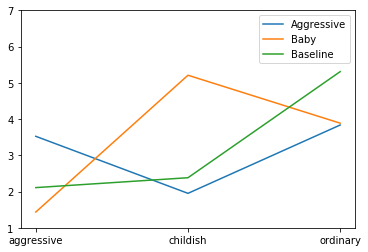


Design check for data Bitzer

design      Baseline  Aggressive      Baby
aggressive  2.741935    3.037037  1.939394
childish    2.258065    2.074074  4.848485
ordinary    5.129032    4.000000  3.939394


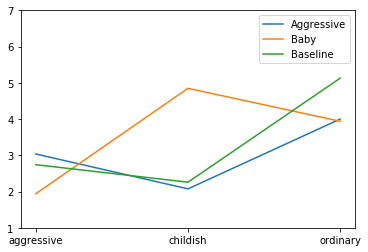


Design check for data merged

design      Baseline  Aggressive      Baby
aggressive  2.337209    3.375000  1.610526
childish    2.337209    1.988636  5.084211
ordinary    5.244186    3.886364  3.905263


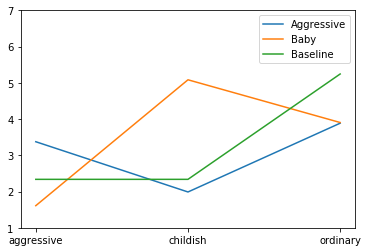

In [18]:
# Display perceptions of design

def design_check(data):
    means_by_cond = pd.pivot_table(data, values=['childish', 'ordinary', 'aggressive'], index=['design'])
    design_means = means_by_cond.T
    print(design_means)
    fig = plt.figure()
    plt.plot(design_means['Aggressive'])
    plt.plot(design_means['Baby'])
    plt.plot(design_means['Baseline'])

    plt.legend(['Aggressive', 'Baby', 'Baseline'])
    plt.xticks([0,1,2], labels=['aggressive', 'childish', 'ordinary'])
    plt.ylim(1,7)

    plt.show()
    
print('Design check for data Hildebrand\n')
design_check(data1)
print('\nDesign check for data Bitzer\n')
design_check(data2)
print('\nDesign check for data merged\n')
design_check(data)
    



In [19]:
# T-tests for manipulation check

def t_test_design(data):
    design = {0:'Baby', 1:'Aggressive'}
    for perception in ['ordinary', 'childish', 'aggressive']: 
        print('T-tests for {}'.format(perception)+'\n')
        for i in design:
            t, p = stats.ttest_ind(data[data['design']=='Baseline'][perception], 
                                   data[data['design']==design[i]][perception], nan_policy='omit')
            print('Mean difference between Baseline and {}: t = {}, p = {}'.format(design[i], round(t,3), round(p,3)),'\n')
            
print('T-tests design for data Hildebrand\n')
t_test_design(data1)
print('\nT-tests design for data Bitzer\n')
t_test_design(data2)
print('\nT-tests design for data merged\n')
t_test_design(data)

T-tests design for data Hildebrand

T-tests for ordinary

Mean difference between Baseline and Baby: t = 4.818, p = 0.0 

Mean difference between Baseline and Aggressive: t = 4.338, p = 0.0 

T-tests for childish

Mean difference between Baseline and Baby: t = -8.566, p = 0.0 

Mean difference between Baseline and Aggressive: t = 1.591, p = 0.114 

T-tests for aggressive

Mean difference between Baseline and Baby: t = 3.362, p = 0.001 

Mean difference between Baseline and Aggressive: t = -4.47, p = 0.0 


T-tests design for data Bitzer

T-tests for ordinary

Mean difference between Baseline and Baby: t = 2.781, p = 0.007 

Mean difference between Baseline and Aggressive: t = 2.423, p = 0.019 

T-tests for childish

Mean difference between Baseline and Baby: t = -5.883, p = 0.0 

Mean difference between Baseline and Aggressive: t = 0.482, p = 0.632 

T-tests for aggressive

Mean difference between Baseline and Baby: t = 1.874, p = 0.066 

Mean difference between Baseline and Aggressive

## Two-factorial ANOVAS for responsibility attribution 

In [20]:
#check relevant variables

def check_vars(data):
    print(data[['Resp_Bic', 'Resp_Car', 'Resp_Driver', 'Resp_Producer']].describe()) #check min and max
    print('\nMissing values\n',data[['Resp_Bic', 'Resp_Car', 'Resp_Driver', 'Resp_Producer']].isna().sum()) #check for missing values
    
print('Data Hildebrand\n')
check_vars(data1)

print('Data Bitzer\n')
check_vars(data2)

print('\nData merged\n')
check_vars(data)

Data Hildebrand

         Resp_Bic    Resp_Car  Resp_Driver  Resp_Producer
count  178.000000  178.000000   178.000000     178.000000
mean     2.258427    4.730337     4.589888       4.876404
std      1.555221    1.897152     2.164247       1.981954
min      1.000000    1.000000     1.000000       1.000000
25%      1.000000    4.000000     3.000000       4.000000
50%      2.000000    5.000000     5.000000       5.000000
75%      3.000000    6.000000     7.000000       7.000000
max      7.000000    7.000000     7.000000       7.000000

Missing values
 Resp_Bic         0
Resp_Car         0
Resp_Driver      0
Resp_Producer    0
dtype: int64
Data Bitzer

        Resp_Bic   Resp_Car  Resp_Driver  Resp_Producer
count  91.000000  91.000000    91.000000      91.000000
mean    2.791209   4.571429     5.065934       5.241758
std     1.834948   2.033841     2.009987       1.727816
min     1.000000   1.000000     1.000000       1.000000
25%     1.000000   4.000000     4.000000       4.000000
50%   

In [21]:
# Two-factorial ANOVAS

def anova(data):
    for resp in ['Resp_Bic', 'Resp_Car', 'Resp_Driver', 'Resp_Producer']:
        formula = '{} ~ C(level) + C(design) + C(level):C(design)'.format(resp)
        model = ols(formula, data).fit()
        aov_table = anova_lm(model, typ=2)
        eta_squared(aov_table)
        print('ANOVA on {}'.format(resp)+'\n',aov_table.round(4))
        print('\n')
        
print('Data Hildebrand\n')
anova(data1)

print('Data Bitzer\n')
anova(data2)

print('\nData merged\n')
anova(data)

Data Hildebrand

ANOVA on Resp_Bic
                       sum_sq     df       F  PR(>F)  eta_sq
C(level)              1.6006    1.0  0.6534  0.4200  0.0037
C(design)             4.5712    2.0  0.9330  0.3954  0.0107
C(level):C(design)    1.0036    2.0  0.2048  0.8150  0.0023
Residual            421.3534  172.0     NaN     NaN     NaN


ANOVA on Resp_Car
                       sum_sq     df       F  PR(>F)  eta_sq
C(level)             15.5298    1.0  4.4912  0.0355  0.0244
C(design)             1.6489    2.0  0.2384  0.7881  0.0026
C(level):C(design)   24.5959    2.0  3.5565  0.0307  0.0386
Residual            594.7529  172.0     NaN     NaN     NaN


ANOVA on Resp_Driver
                       sum_sq     df        F  PR(>F)  eta_sq
C(level)             98.8774    1.0  23.8971  0.0000  0.1191
C(design)            10.1467    2.0   1.2261  0.2960  0.0122
C(level):C(design)    9.6105    2.0   1.1614  0.3155  0.0116
Residual            711.6711  172.0      NaN     NaN     NaN


ANOVA on Res

ANOVA Plots for data Hildebrand



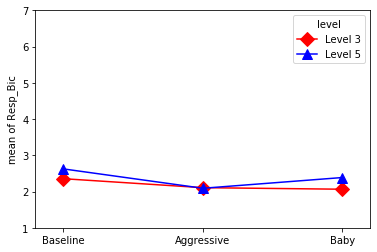

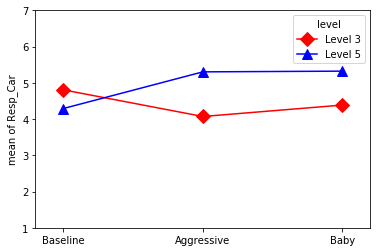

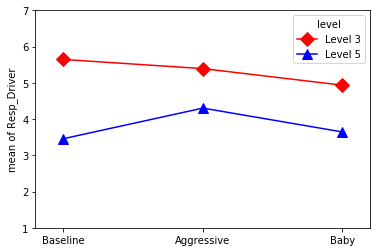

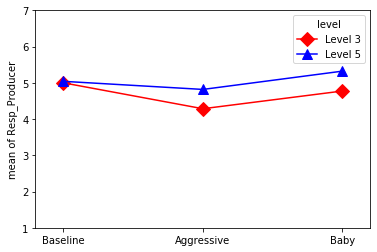


ANOVA Plots for data Bitzer



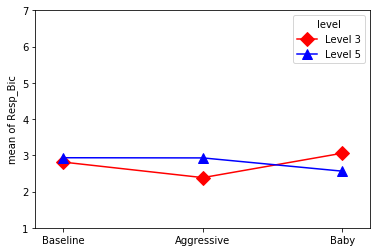

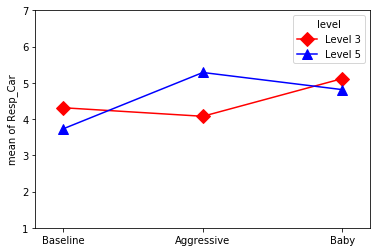

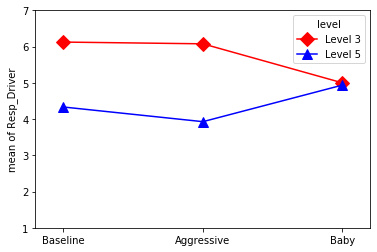

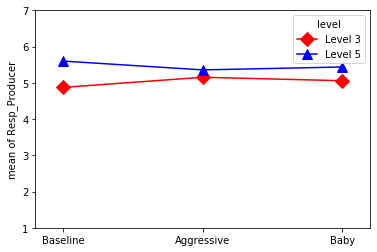

ANOVA Plots for data merged



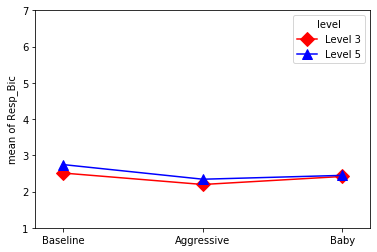

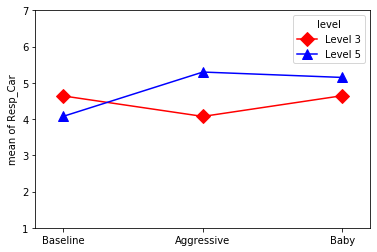

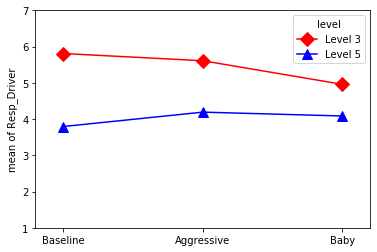

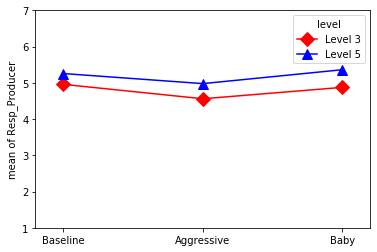

In [23]:
# Visualizing factorial data with statsmodel interaction_plot

def plot(data):
    for resp in ['Resp_Bic', 'Resp_Car', 'Resp_Driver', 'Resp_Producer']:
        fig = interaction_plot(x=data['design'].cat.codes, trace=data['level'], response=data[resp], 
                       colors=['red', 'blue'], markers=['D', '^'], ms=10)
        plt.xticks([0,1,2], labels=['Baseline', 'Aggressive', 'Baby'])
        plt.ylim(1,7)
        plt.show()
        
print('ANOVA Plots for data Hildebrand\n')
plot(data1)
print('\nANOVA Plots for data Bitzer\n')
plot(data2)
print('ANOVA Plots for data merged\n')
plot(data)

In [24]:
#Post-hoc testing of mean differences for different levels of automation

# display mean values and std. deviations by level and design

def display_means(data):
    print(pd.pivot_table(data, values=['Resp_Bic', 'Resp_Car', 'Resp_Driver', 'Resp_Producer'], 
                   index=['level', 'design'], aggfunc=[np.mean, np.std]))
    

print('Means for data Hildebrand\n')
display_means(data1)
print('\nMeans for data Bitzer\n')
display_means(data2)
print('\nMeans for data merged\n')
display_means(data)

Means for data Hildebrand

                        mean                                           std  \
                    Resp_Bic  Resp_Car Resp_Driver Resp_Producer  Resp_Bic   
level   design                                                               
Level 3 Baseline    2.354839  4.806452    5.645161      5.000000  1.835727   
        Aggressive  2.107143  4.071429    5.392857      4.285714  1.165532   
        Baby        2.064516  4.387097    4.935484      4.774194  1.481789   
Level 5 Baseline    2.625000  4.291667    3.458333      5.041667  1.813296   
        Aggressive  2.090909  5.303030    4.303030      4.818182  1.444032   
        Baby        2.387097  5.322581    3.645161      5.322581  1.584875   

                                                        
                    Resp_Car Resp_Driver Resp_Producer  
level   design                                          
Level 3 Baseline    2.023518    1.473055      1.932184  
        Aggressive  1.631372    1.770944  

In [25]:
#For each automation level and outcome, display t-tests of mean differences depending on design

#Anotation design:
#0 = baseline
#1 = aggressive
#2 = babyfaced

#Annotation automation level:
#0 = Level 3
#1 = Level 5

design = ['baseline', 'aggressive', 'babyfaced']

def t_tests(data):
    for resp in ['Resp_Bic', 'Resp_Car', 'Resp_Driver', 'Resp_Producer']:
        for level in sorted(data['level'].unique()):
            print('\nT-tests for {} on automation level {}'.format(resp, level))
            values = data[data['level']==level][['design', resp]]
            for i in range(len(design)):
                if i == 2:
                    one = 0
                    two = 2
                else:                        
                    one = i
                    two = i+1
            
                if stats.levene(values[values['design'].cat.codes==one][resp], 
                            values[values['design'].cat.codes==two][resp])[1] < .05:
                    t, p = stats.ttest_ind(values[values['design'].cat.codes==one][resp], 
                                       values[values['design'].cat.codes==two][resp], equal_var=False)
                else:
                    t, p = stats.ttest_ind(values[values['design'].cat.codes==one][resp], 
                                       values[values['design'].cat.codes==two][resp])
                print('Comparing means of {} and {}: t-value = {}, p = {}'.format(design[one], design[two],
                                                                                  round(t,4), round(p,4)))
                

print('T-tests for data Hildebrand\n')
t_tests(data1)
print('\nT-tests for data Bitzer\n')
t_tests(data2)
print('\nT-tests for data merged\n')
t_tests(data)

T-tests for data Hildebrand


T-tests for Resp_Bic on automation level Level 3
Comparing means of baseline and aggressive: t-value = 0.6111, p = 0.5436
Comparing means of aggressive and babyfaced: t-value = 0.1219, p = 0.9034
Comparing means of baseline and babyfaced: t-value = 0.6852, p = 0.4959

T-tests for Resp_Bic on automation level Level 5
Comparing means of baseline and aggressive: t-value = 1.2375, p = 0.2212
Comparing means of aggressive and babyfaced: t-value = -0.7822, p = 0.437
Comparing means of baseline and babyfaced: t-value = 0.5184, p = 0.6063

T-tests for Resp_Car on automation level Level 3
Comparing means of baseline and aggressive: t-value = 1.5254, p = 0.1327
Comparing means of aggressive and babyfaced: t-value = -0.6509, p = 0.5177
Comparing means of baseline and babyfaced: t-value = 0.8118, p = 0.4201

T-tests for Resp_Car on automation level Level 5
Comparing means of baseline and aggressive: t-value = -1.9974, p = 0.0507
Comparing means of aggressive and babyf

## Evaluate effect of design on mediators

In [26]:
def check_vars(data):
    print(data[['car_comp1', 'car_comp2', 'car_comp3', 'car_comp4',
       'car_comp5', 'car_consc1', 'car_consc2', 'car_consc3', 'car_consc4',
       'car_consc5', 'car_consc6', 'driv_comp1', 'driv_comp2', 'driv_comp3',
       'driv_comp4', 'driv_comp5', 'driv_consc1', 'driv_consc2', 'driv_consc3',
       'driv_consc4']].describe())

    print(data[['car_comp1', 'car_comp2', 'car_comp3', 'car_comp4',
       'car_comp5', 'car_consc1', 'car_consc2', 'car_consc3', 'car_consc4',
       'car_consc5', 'car_consc6', 'driv_comp1', 'driv_comp2', 'driv_comp3',
       'driv_comp4', 'driv_comp5', 'driv_consc1', 'driv_consc2', 'driv_consc3',
       'driv_consc4']].isnull().sum())
    
print('Data Hildebrand\n')
check_vars(data1)
print('\nData Bitzer\n')
check_vars(data2)
print('\nData merged\n')
check_vars(data)

Data Hildebrand

        car_comp1   car_comp2   car_comp3   car_comp4   car_comp5  car_consc1  \
count  178.000000  178.000000  178.000000  178.000000  178.000000  178.000000   
mean     4.943820    4.393258    4.533708    4.584270    4.724719    4.213483   
std      1.632021    1.694911    1.609116    1.603731    1.611244    1.813147   
min      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%      4.000000    3.000000    3.000000    3.250000    4.000000    3.000000   
50%      5.000000    4.000000    5.000000    5.000000    5.000000    4.000000   
75%      6.000000    6.000000    6.000000    6.000000    6.000000    6.000000   
max      7.000000    7.000000    7.000000    7.000000    7.000000    7.000000   

       car_consc2  car_consc3  car_consc4  car_consc5  car_consc6  driv_comp1  \
count  178.000000  178.000000  178.000000  178.000000  178.000000  178.000000   
mean     4.365169    4.117978    4.174157    3.617978    3.651685    4.696629   
std      1

In [27]:
#delete one missing case in driv_consc1

def del_case(data):
    print(data.shape)
    data = data[data['driv_consc1'] > 0]
    print(data.shape)
    return data

data1 = del_case(data1)
data = del_case(data)


(178, 52)
(177, 52)
(269, 52)
(268, 52)


In [28]:
#Check scale reliabilities

def reliability(data):
    print('Reliability of car competence:',CronbachAlpha(data[['car_comp1', 'car_comp2', 'car_comp3', 'car_comp4',
       'car_comp5']]))
    print('Reliability of car conscientiousness:',CronbachAlpha(data[['car_consc1', 'car_consc2', 'car_consc3', 'car_consc4']]))
    print('Reliability of driver competence:',CronbachAlpha(data[['driv_comp1', 'driv_comp2', 'driv_comp3',
       'driv_comp4', 'driv_comp5']]))
    print('Reliability of driver conscientiousness:',CronbachAlpha(data[['driv_consc1', 'driv_consc2', 'driv_consc3',
       'driv_consc4']]))
    
print('Data Hildebrand')
reliability(data1)
print('\nData Bitzer')
reliability(data2)
print('\nData merged')
reliability(data)

Data Hildebrand
Reliability of car competence: 0.9407929541902128
Reliability of car conscientiousness: 0.92133413062255
Reliability of driver competence: 0.9563406929184546
Reliability of driver conscientiousness: 0.9428467229342502

Data Bitzer
Reliability of car competence: 0.8950808459171932
Reliability of car conscientiousness: 0.9171432780749955
Reliability of driver competence: 0.9454320376330776
Reliability of driver conscientiousness: 0.9226189129183041

Data merged
Reliability of car competence: 0.9274970111081594
Reliability of car conscientiousness: 0.9198711615436859
Reliability of driver competence: 0.9530953921706922
Reliability of driver conscientiousness: 0.9382438827349274


In [29]:
# Sufficient reliability, calculate construct measures

def constructs(data):
    data['car_comp'] = data[['car_comp1', 'car_comp2', 'car_comp3', 'car_comp4', 'car_comp5']].mean(axis=1)
    data['car_consc'] = data[['car_consc1', 'car_consc2', 'car_consc3', 'car_consc4']].mean(axis=1)    
    data['driv_comp'] = data[['driv_comp1', 'driv_comp2', 'driv_comp3', 'driv_comp4', 'driv_comp5']].mean(axis=1)
    data['driv_consc'] = data[['driv_consc1', 'driv_consc2', 'driv_consc3', 'driv_consc4']].mean(axis=1)
    print(data[['car_comp', 'car_consc', 'driv_comp', 'driv_consc']].describe())
    return data

print('Data Hildebrand')
data1 = constructs(data1)
print('Data merged')
data = constructs(data)
print('Data Bitzer')
data2 = constructs(data2)

Data Hildebrand
         car_comp   car_consc   driv_comp  driv_consc
count  177.000000  177.000000  177.000000  177.000000
mean     4.622599    4.201977    4.527684    4.271186
std      1.461455    1.579956    1.567631    1.665122
min      1.000000    1.000000    1.000000    1.000000
25%      3.800000    3.250000    3.400000    3.000000
50%      4.800000    4.250000    4.600000    4.250000
75%      5.800000    5.250000    5.800000    5.500000
max      7.000000    7.000000    7.000000    7.000000
Data merged
         car_comp   car_consc   driv_comp  driv_consc
count  268.000000  268.000000  268.000000  268.000000
mean     4.661940    4.228545    4.557463    4.415112
std      1.404183    1.557799    1.512142    1.596909
min      1.000000    1.000000    1.000000    1.000000
25%      3.800000    3.250000    3.750000    3.437500
50%      4.800000    4.250000    4.700000    4.500000
75%      5.800000    5.250000    5.650000    5.750000
max      7.000000    7.000000    7.000000    7.000000


Data Hildebrand



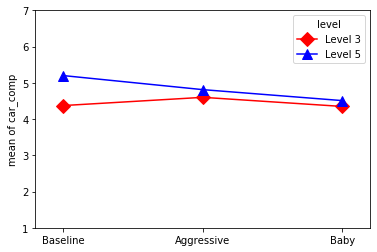

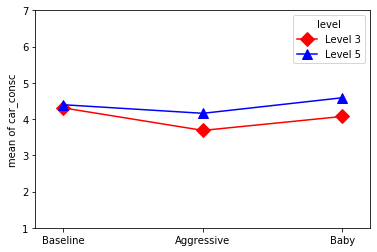

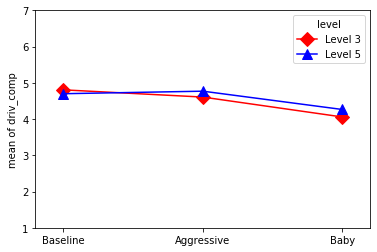

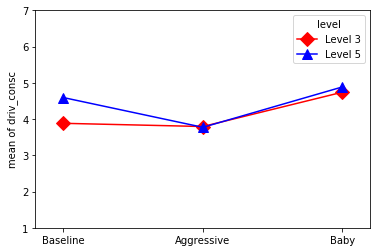


Data Bitzer



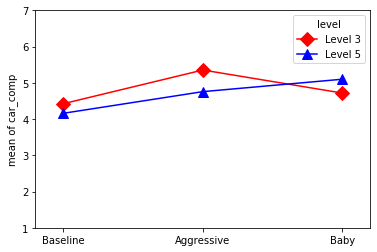

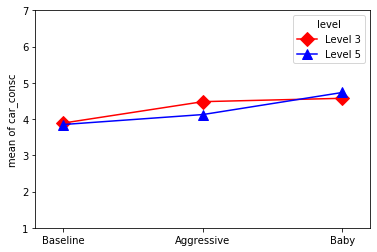

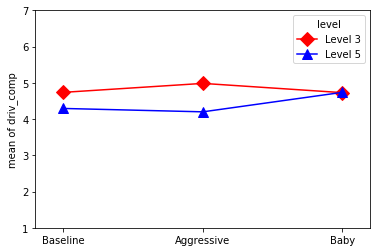

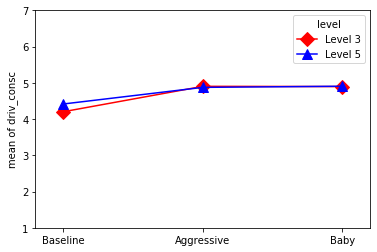


Data merged



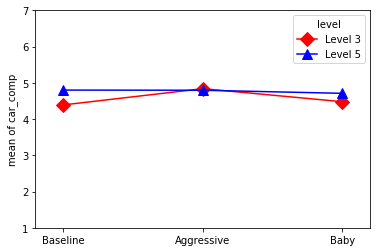

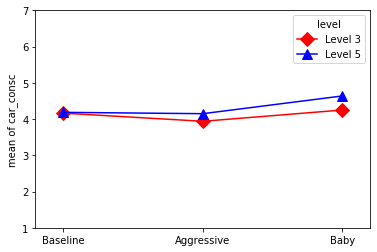

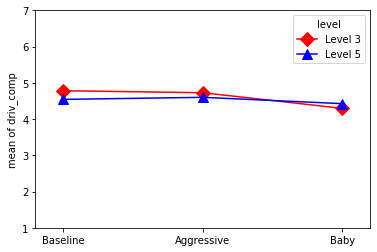

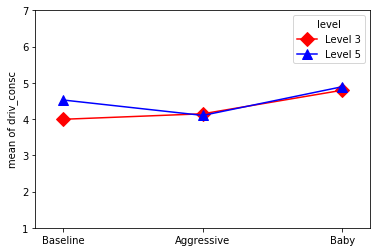

In [30]:
# Illustrate impact of design and automation level on attributions to car and driver

def plot(data):
    for attribution in ['car_comp', 'car_consc', 'driv_comp', 'driv_consc']:
        fig = interaction_plot(x=data['design'].cat.codes, trace=data['level'], response=data[attribution], 
                       colors=['red', 'blue'], markers=['D', '^'], ms=10)
        plt.xticks([0,1,2], labels=['Baseline', 'Aggressive', 'Baby'])
        plt.ylim(1,7)
        plt.show()
        
print('Data Hildebrand\n')
plot(data1)
print('\nData Bitzer\n')
plot(data2)
print('\nData merged\n')
plot(data)


In [31]:
# Two-factorial ANOVAS

def anovas(data):
    for attribution in ['car_comp', 'car_consc', 'driv_comp', 'driv_consc']:
        formula = '{} ~ C(level) + C(design) + C(level):C(design)'.format(attribution)
        model = ols(formula, data).fit()
        aov_table = anova_lm(model, typ=2)
        eta_squared(aov_table)
        print('ANOVA on {}'.format(attribution)+'\n',aov_table.round(4))
        print('\n')
        
print('Data Hildebrand')
anovas(data1)
print('\nData Bitzer')
anovas(data2)
print('\nData merged')
anovas(data)

Data Hildebrand
ANOVA on car_comp
                       sum_sq     df       F  PR(>F)  eta_sq
C(level)              6.3680    1.0  3.0071  0.0847  0.0169
C(design)             3.7268    2.0  0.8799  0.4167  0.0099
C(level):C(design)    3.8285    2.0  0.9039  0.4069  0.0102
Residual            362.1183  171.0     NaN     NaN     NaN


ANOVA on car_consc
                       sum_sq     df       F  PR(>F)  eta_sq
C(level)              6.0485    1.0  2.4309  0.1208  0.0137
C(design)             7.0780    2.0  1.4223  0.2440  0.0161
C(level):C(design)    1.5514    2.0  0.3118  0.7326  0.0035
Residual            425.4731  171.0     NaN     NaN     NaN


ANOVA on driv_comp
                       sum_sq     df       F  PR(>F)  eta_sq
C(level)              0.4088    1.0  0.1671  0.6832  0.0009
C(design)            12.9820    2.0  2.6530  0.0733  0.0300
C(level):C(design)    0.8038    2.0  0.1643  0.8486  0.0019
Residual            418.3734  171.0     NaN     NaN     NaN


ANOVA on driv_consc

In [33]:
#For each automation level and outcome, display t-tests of mean differences depending on design

#Anotation design:
#0 = baseline
#1 = aggressive
#2 = babyfaced

#Annotation automation level:
#0 = Level 3
#1 = Level 5

design = ['baseline', 'aggressive', 'babyfaced']

def t_tests(data):
    for attribution in ['car_comp', 'car_consc', 'driv_comp', 'driv_consc']:
        for level in sorted(data['level'].unique()):
            print('\nT-tests for {} on automation level {}'.format(attribution, level))
            values = data[data['level']==level][['design', attribution]]
            for i in range(len(design)):
                if i == 2:
                    one = 0
                    two = 2
                else:                        
                    one = i
                    two = i+1
            
                if stats.levene(values[values['design'].cat.codes==one][attribution], 
                            values[values['design'].cat.codes==two][attribution])[1] < .05:
                    t, p = stats.ttest_ind(values[values['design'].cat.codes==one][attribution], 
                                       values[values['design'].cat.codes==two][attribution], equal_var=False)
                else:
                    t, p = stats.ttest_ind(values[values['design'].cat.codes==one][attribution], 
                                       values[values['design'].cat.codes==two][attribution])
                print('Comparing means of {} and {}: t-value = {}, p = {}'.format(design[one], design[two], 
                                                                                  round(t,4), round(p,4)))
                

print('T-tests for data Hildebrand\n')
t_tests(data1)
print('\nT-tests for data Bitzer\n')
t_tests(data2)
print('\nT-tests for data merged\n')
t_tests(data)

T-tests for data Hildebrand


T-tests for car_comp on automation level Level 3
Comparing means of baseline and aggressive: t-value = -0.5766, p = 0.5665
Comparing means of aggressive and babyfaced: t-value = 0.6454, p = 0.5212
Comparing means of baseline and babyfaced: t-value = 0.0688, p = 0.9454

T-tests for car_comp on automation level Level 5
Comparing means of baseline and aggressive: t-value = 1.005, p = 0.3193
Comparing means of aggressive and babyfaced: t-value = 0.8518, p = 0.3976
Comparing means of baseline and babyfaced: t-value = 1.7289, p = 0.0897

T-tests for car_consc on automation level Level 3
Comparing means of baseline and aggressive: t-value = 1.4612, p = 0.1503
Comparing means of aggressive and babyfaced: t-value = -0.9017, p = 0.3716
Comparing means of baseline and babyfaced: t-value = 0.6765, p = 0.5014

T-tests for car_consc on automation level Level 5
Comparing means of baseline and aggressive: t-value = 0.5592, p = 0.5783
Comparing means of aggressive and baby

## Correlates between attributions to car and driver and responsibility ascription


In [34]:
# Function to calculate p-values

from scipy.stats import pearsonr

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

In [35]:
#present correlation tables with significance information

def corr_table(data):
    rho = data[['Resp_Bic', 'Resp_Car', 'Resp_Driver', 'Resp_Producer', 
                'car_comp', 'car_consc', 'driv_comp', 'driv_consc']].corr()
    rho = rho.round(2)
    pval = calculate_pvalues(data[['Resp_Bic', 'Resp_Car', 'Resp_Driver', 'Resp_Producer', 
                                   'car_comp', 'car_consc', 'driv_comp', 'driv_consc']]) 
    # create three masks
    r1 = rho.applymap(lambda x: '{}*'.format(x))
    r2 = rho.applymap(lambda x: '{}**'.format(x))
    r3 = rho.applymap(lambda x: '{}***'.format(x))
    # apply them where appropriate
    rho = rho.mask(pval<=0.1,r1)
    rho = rho.mask(pval<=0.05,r2)
    rho = rho.mask(pval<=0.01,r3)
    print(rho)
    
print('Data Hildebrand\n')
corr_table(data1)
print('\nData Bitzer\n')
corr_table(data2)
print('\nData merged\n')
corr_table(data)

Data Hildebrand

               Resp_Bic  Resp_Car Resp_Driver Resp_Producer  car_comp  \
Resp_Bic         1.0***  -0.25***     -0.19**      -0.31***      0.07   
Resp_Car       -0.25***    1.0***        -0.1       0.42***     -0.02   
Resp_Driver     -0.19**      -0.1      1.0***        -0.13*  -0.24***   
Resp_Producer  -0.31***   0.42***      -0.13*        1.0***      0.08   
car_comp           0.07     -0.02    -0.24***          0.08    1.0***   
car_consc          0.06      0.07       -0.12          0.02   0.49***   
driv_comp         0.13*     -0.05        0.05         -0.11   0.32***   
driv_consc         0.01      0.01       -0.06          0.01    0.17**   

              car_consc driv_comp driv_consc  
Resp_Bic           0.06     0.13*       0.01  
Resp_Car           0.07     -0.05       0.01  
Resp_Driver       -0.12      0.05      -0.06  
Resp_Producer      0.02     -0.11       0.01  
car_comp        0.49***   0.32***     0.17**  
car_consc        1.0***   0.31***    0.49**

In [75]:
corr_table(data2)

              Resp_Bic Resp_Car Resp_Driver Resp_Producer car_comp car_consc  \
Resp_Bic        1.0***  -0.24**       -0.09       -0.4***     0.06      0.13   
Resp_Car       -0.24**   1.0***       -0.12        0.27**     0.16      0.2*   
Resp_Driver      -0.09    -0.12      1.0***         -0.07    -0.05      0.09   
Resp_Producer  -0.4***   0.27**       -0.07        1.0***      0.1      0.03   
car_comp          0.06     0.16       -0.05           0.1   1.0***   0.54***   
car_consc         0.13     0.2*        0.09          0.03  0.54***    1.0***   
driv_comp        0.19*     0.13      0.25**         -0.04  0.47***   0.44***   
driv_consc        0.08    0.18*        0.02           0.1  0.48***   0.63***   

              driv_comp driv_consc  
Resp_Bic          0.19*       0.08  
Resp_Car           0.13      0.18*  
Resp_Driver      0.25**       0.02  
Resp_Producer     -0.04        0.1  
car_comp        0.47***    0.48***  
car_consc       0.44***    0.63***  
driv_comp        1.0

In [49]:
# Only singifcant relationship (negative) between car competence and responsibility of driver

## Check moderated mediation analysis

In [36]:
# add dummy columns to dataframe about car design

def dummies(data):
    aggr_dict = {'Baseline' : 0, 'Baby' : 0, 'Aggressive' : 1}
    baby_dict = {'Baseline' : 0, 'Baby' : 1, 'Aggressive' : 0}
    # Add a new columns
    data['aggr_design'] = data['design'].map(aggr_dict).astype('int64')
    data['baby_design'] = data['design'].map(baby_dict).astype('int64')
    data['level_int'] = data['level'].cat.codes
    print(data.columns)
    return data

data1 = dummies(data1)
data2 = dummies(data2)
data = dummies(data)

Index(['lfdn', 'duration', 'c_0001', 'Trust_Car_1', 'Trust_Car_2',
       'Trust_Car_3', 'car_check', 'childish', 'ordinary', 'aggressive',
       'car_comp1', 'car_comp2', 'car_comp3', 'car_comp4', 'car_comp5',
       'car_consc1', 'car_consc2', 'car_consc3', 'car_consc4', 'car_consc5',
       'car_consc6', 'driv_comp1', 'driv_comp2', 'driv_comp3', 'driv_comp4',
       'driv_comp5', 'driv_consc1', 'driv_consc2', 'driv_consc3',
       'driv_consc4', 'Resp_Bic', 'Resp_Car', 'Resp_Driver', 'Resp_Producer',
       'Sex', 'Age', 'Car_Owner', 'km_year', 'Education', 'Occupation',
       'Occupation_Sonst', 'Income', 'Quality_1', 'Quality_2', 'Quality_3',
       'Quality_4', 'Quality_5', 'Quality_6', 'datetime',
       'date_of_last_access', 'level', 'design', 'car_comp', 'car_consc',
       'driv_comp', 'driv_consc', 'aggr_design', 'baby_design', 'level_int'],
      dtype='object')
Index(['lfdn', 'duration', 'c_0001', 'Trust_Car_1', 'Trust_Car_2',
       'Trust_Car_3', 'car_check', 'childis

### Parsimonious model 7: x = design, w = level, m = driv_consc, y = [Resp_Car, Resp_Driver, Resp_Producer]

In [38]:
#Import process library
from pyprocessmacro import Process

In [49]:
#Instantiate process object and show results

datasets = {'Data Hildebrand':data1, 'Data Bitzer':data2, 'Data merged':data}

for k, v in datasets.items():
    print('\n'+r'++++++++++++++++ Analysis of {} ++++++++++++++++'.format(k)+'\n')
    for y in ['Resp_Car', 'Resp_Driver', 'Resp_Producer']:
        for x in ['aggr_design', 'baby_design']:
            p = Process(data=v, model=7, x=x, y=y, w="level_int", 
                        m=["driv_consc"],
                        controls = [c for c in ['aggr_design', 'baby_design'] if c!=x], controls_in = 'all')
        p.summary()


++++++++++++++++ Analysis of Data Hildebrand ++++++++++++++++

Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 7

Variables:
    Cons = Cons
    x = aggr_design
    y = Resp_Car
    w = level_int
    m1 = driv_consc
Statistical Controls:
 baby_design



Sample size:
177

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0
Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 7

Variables:
    Cons = Cons
    x = baby_design
    y = Resp_Car
    w = level_int
    m1 = driv_consc
Statistical Controls:
 aggr_design



Sample size:
177

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
N

Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 7

Variables:
    Cons = Cons
    x = aggr_design
    y = Resp_Car
    w = level_int
    m1 = driv_consc
Statistical Controls:
 baby_design



Sample size:
91

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0
Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 7

Variables:
    Cons = Cons
    x = baby_design
    y = Resp_Car
    w = level_int
    m1 = driv_consc
Statistical Controls:
 aggr_design



Sample size:
91

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

*********

Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 7

Variables:
    Cons = Cons
    x = aggr_design
    y = Resp_Car
    w = level_int
    m1 = driv_consc
Statistical Controls:
 baby_design



Sample size:
268

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0
Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 7

Variables:
    Cons = Cons
    x = baby_design
    y = Resp_Car
    w = level_int
    m1 = driv_consc
Statistical Controls:
 aggr_design



Sample size:
268

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

*******

### Full model 7: x = design, w = level, m = car_comp, car_consc, driv_comp, driv_consc, y = [Resp_Car, Resp_Driver, Resp_Producer]

In [50]:
#Instantiate process object and show results

for y in ['Resp_Car', 'Resp_Driver', 'Resp_Producer']:
    for x in ['aggr_design', 'baby_design']:
        p = Process(data=data, model=7, x=x, y=y, w="level_int", 
            m=["car_comp", "car_consc", "driv_comp", "driv_consc"],
           controls = [c for c in ['aggr_design', 'baby_design'] if c!=x], controls_in = 'all')
        p.summary()

Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 7

Variables:
    Cons = Cons
    x = aggr_design
    y = Resp_Car
    w = level_int
    m1 = car_comp
    m2 = car_consc
    m3 = driv_comp
    m4 = driv_consc
Statistical Controls:
 baby_design



Sample size:
268

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = Resp_Car 
OLS Regression Summary

     R²  Adj. R²    MSE      F  df1  df2  p-value
 0.0250  -0.0013 3.7255 1.1153    6  261   0.3537

Coefficients

              coeff     se       t      p    LLCI   ULCI
Cons         4.0903 0.6006  6.8103 0.0000  2.9131 5.2674
aggr_design  0.3377 0.3071  1.0995 0.2726 -0.2643 0.9397
baby_design  0.4190 0.3005  1.3943 0.1644 

Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 7

Variables:
    Cons = Cons
    x = aggr_design
    y = Resp_Driver
    w = level_int
    m1 = car_comp
    m2 = car_consc
    m3 = driv_comp
    m4 = driv_consc
Statistical Controls:
 baby_design



Sample size:
268

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = Resp_Driver 
OLS Regression Summary

     R²  Adj. R²    MSE      F  df1  df2  p-value
 0.0732   0.0482 4.2336 3.4339    6  261   0.0028

Coefficients

              coeff     se       t      p    LLCI    ULCI
Cons         5.4534 0.6227  8.7575 0.0000  4.2329  6.6739
aggr_design  0.0060 0.3053  0.0197 0.9843 -0.5923  0.6043
baby_design -0.3068 0.3221 -0.952

Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 7

Variables:
    Cons = Cons
    x = aggr_design
    y = Resp_Producer
    w = level_int
    m1 = car_comp
    m2 = car_consc
    m3 = driv_comp
    m4 = driv_consc
Statistical Controls:
 baby_design



Sample size:
268

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = Resp_Producer 
OLS Regression Summary

     R²  Adj. R²    MSE      F  df1  df2  p-value
 0.0353   0.0093 3.5333 1.5918    6  261   0.1497

Coefficients

              coeff     se       t      p    LLCI   ULCI
Cons         4.9257 0.5352  9.2036 0.0000  3.8768 5.9747
aggr_design -0.4036 0.2977 -1.3560 0.1763 -0.9870 0.1798
baby_design -0.1244 0.2815 -0.44

### Two mediators model 7: x = design, w = level, m = car_consc, driv_consc, y = [Resp_Car, Resp_Driver, Resp_Producer]

In [71]:
#Instantiate process object and show results

for y in ['Resp_Car', 'Resp_Driver', 'Resp_Producer']:
    for x in ['aggr_design', 'baby_design']:
        p = Process(data=data, model=7, x=x, y=y, w="level_int", 
            m=["car_consc", "driv_consc"],
           controls = [c for c in ['aggr_design', 'baby_design'] if c!=x], controls_in = 'all')
        p.summary()

Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 7

Variables:
    Cons = Cons
    x = aggr_design
    y = Resp_Car
    w = level_int
    m1 = car_consc
    m2 = driv_consc
Statistical Controls:
 baby_design



Sample size:
261

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = Resp_Car 
OLS Regression Summary

     R²  Adj. R²    MSE      F  df1  df2  p-value
 0.0204   0.0012 3.6951 1.3340    4  256   0.2577

Coefficients

              coeff     se       t      p    LLCI   ULCI
Cons         3.9000 0.4726  8.2521 0.0000  2.9737 4.8263
aggr_design  0.3919 0.3064  1.2788 0.2021 -0.2087 0.9925
baby_design  0.4491 0.2998  1.4983 0.1353 -0.1384 1.0367
car_consc    0.1259 0.

Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 7

Variables:
    Cons = Cons
    x = baby_design
    y = Resp_Driver
    w = level_int
    m1 = car_consc
    m2 = driv_consc
Statistical Controls:
 aggr_design



Sample size:
261

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = Resp_Driver 
OLS Regression Summary

     R²  Adj. R²    MSE      F  df1  df2  p-value
 0.0072  -0.0123 4.4647 0.4622    4  256   0.7634

Coefficients

              coeff     se       t      p    LLCI   ULCI
Cons         5.0675 0.5080  9.9758 0.0000  4.0719 6.0631
baby_design -0.3399 0.3325 -1.0225 0.3075 -0.9916 0.3117
aggr_design -0.0817 0.3227 -0.2532 0.8003 -0.7142 0.5508
car_consc   -0.0

## Repeat process analysis with respondents reporting that they have looked extensively at the pictures

In [51]:
for column in ['Quality_1', 'Quality_2', 'Quality_3', 
               'Quality_4', 'Quality_5', 'Quality_6']:
    print(data1[column].value_counts().sort_index())

1     7
2     3
3     4
4    15
5    14
6    37
7    97
Name: Quality_1, dtype: int64
1    107
2     27
3     15
4     15
5      6
6      4
7      3
Name: Quality_2, dtype: int64
1      2
2      2
3      1
4      2
5      7
6     24
7    139
Name: Quality_3, dtype: int64
2      2
3      1
4      3
5     14
6     29
7    128
Name: Quality_4, dtype: int64
1    173
3      1
6      1
7      2
Name: Quality_5, dtype: int64
1      1
3      3
4      5
5     13
6     26
7    129
Name: Quality_6, dtype: int64


In [53]:
#only selecting data from Hildebrand, where respondents have intensively watched the stimuli
data_q1 = data1[data1['Quality_4']>5]

In [54]:
for y in ['Resp_Car', 'Resp_Driver', 'Resp_Producer']:
    for x in ['aggr_design', 'baby_design']:
        p = Process(data=data_q1, model=7, x=x, y=y, w="level_int", 
            m=["driv_consc"],
           controls = [c for c in ['aggr_design', 'baby_design'] if c!=x], controls_in = 'all')
        p.summary()

Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 7

Variables:
    Cons = Cons
    x = aggr_design
    y = Resp_Car
    w = level_int
    m1 = driv_consc
Statistical Controls:
 baby_design



Sample size:
157

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = Resp_Car 
OLS Regression Summary

     R²  Adj. R²    MSE      F  df1  df2  p-value
 0.0017  -0.0245 3.7599 0.0886    3  153   0.9662

Coefficients

              coeff     se       t      p    LLCI   ULCI
Cons         4.7424 0.5184  9.1480 0.0000  3.7263 5.7584
aggr_design  0.1240 0.3967  0.3126 0.7550 -0.6535 0.9016
baby_design  0.1992 0.4147  0.4804 0.6316 -0.6136 1.0120
driv_consc  -0.0110 0.0977 -0.1123 0.9107

Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 7

Variables:
    Cons = Cons
    x = aggr_design
    y = Resp_Producer
    w = level_int
    m1 = driv_consc
Statistical Controls:
 baby_design



Sample size:
157

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = Resp_Producer 
OLS Regression Summary

     R²  Adj. R²    MSE      F  df1  df2  p-value
 0.0117  -0.0143 4.1441 0.6045    3  153   0.6130

Coefficients

              coeff     se       t      p    LLCI   ULCI
Cons         5.3498 0.4412 12.1245 0.0000  4.4850 6.2146
aggr_design -0.4653 0.3954 -1.1768 0.2411 -1.2402 0.3096
baby_design -0.0348 0.4152 -0.0837 0.9334 -0.8486 0.7791
driv_consc  -0.0618 0.1031 -0.5